In [ ]:
import sys
sys.path.append("/home/isabrah/sustainable_high_quality_wikis")
import pandas as pd
from os.path import join as opj
import seaborn as sns
import matplotlib.pyplot as plt
import jenkspy
from jenkspy import JenksNaturalBreaks
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator

In [2]:
def shorten_bin_labels(bin_interval, treat_as_int=False):
    # Extract the lower and upper bounds of the interval
    lower, upper = bin_interval.left, bin_interval.right
    # Create a shorter label, e.g., "0-10"
    if treat_as_int:
        lower = int(lower)
        upper = int(upper)
    else:
        lower = round(lower, 2)
        upper = round(upper, 2)
    # handling cases when the zero values get a minus sign
    lower = 0 if lower == -0.0 else lower
    upper = 0 if upper == -0.0 else upper
    return f"[{lower}, {upper})"

In [53]:
# for the paper I ran three sets of features:
# 1. EDIT_num_authors VS COMPOSITION_author_gini
# 2. EDIT_time_to_promotion VS EDIT_num_revisions
# 3. DISCUSSIONS_num_authors VS DISCUSSIONS_sentiment_mean
x_axis_feature = 'EDIT_time_to_promotion'
y_axis_feature = 'EDIT_num_revisions'

In [54]:
model_version = 10.2#20.2
target_column = 'is_sustainable_conservative_approach'#'is_sustained'
base_folder = '/shared/3/projects/relationship-aware-networks-wikipedia'
model_folder = opj(base_folder, 'models')
seed = 1984
binning_method = 'qcut' #jenkspy
min_threshold = 10 # This is the minimal number of obs that should be in order to be drawn in the heatmap. if set to 0 or None, it is not applied at all
include_legend = False#True
save_fig = True

In [55]:
data_df = pd.read_csv(opj(model_folder, str(model_version), 'modeling_df.csv'))
# Set the first column as the index
data_df.set_index(data_df.columns[0], inplace=True)
data_df[target_column] = 1-data_df[target_column].astype(int)
print(data_df.shape)
#data_df.fillna(data_df.mean(), inplace=True)

(7199, 331)


In [56]:
if binning_method == 'qcut':
    data_df[x_axis_feature+'_binned'] = pd.qcut(data_df[x_axis_feature], q=8, duplicates='drop')  # Adjust the number of bins as needed
    data_df[y_axis_feature+'_binned'] = pd.qcut(data_df[y_axis_feature], q=8, duplicates='drop')
    data_df[x_axis_feature+'_binned'] = data_df[x_axis_feature+'_binned'].apply(shorten_bin_labels, args=(True,))
    data_df[y_axis_feature+'_binned'] = data_df[y_axis_feature+'_binned'].apply(shorten_bin_labels, args=(False,))
    pivot_table = data_df.pivot_table(values=target_column, index=y_axis_feature+'_binned', columns=x_axis_feature+'_binned', aggfunc=['mean', 'count'])
elif binning_method == 'jenkspy':
    jnb = JenksNaturalBreaks(8)
    jnb.fit(data_df[x_axis_feature])
    data_df[x_axis_feature+'_binned'] = jnb.labels_
    
    jnb = JenksNaturalBreaks(8)
    jnb.fit(data_df[y_axis_feature])
    data_df[y_axis_feature+'_binned'] = jnb.labels_
    
    pivot_table = data_df.pivot_table(values=target_column, index=y_axis_feature+'_binned', columns=x_axis_feature+'_binned', aggfunc=['mean', 'count'])
    #jenkspy.jenks_breaks(data_df[x_axis_feature], n_classes=8)

/tmp/ipykernel_2373369/350915957.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = data_df.pivot_table(values=target_column, index=y_axis_feature+'_binned', columns=x_axis_feature+'_binned', aggfunc=['mean', 'count'])
/tmp/ipykernel_2373369/350915957.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = data_df.pivot_table(values=target_column, index=y_axis_feature+'_binned', columns=x_axis_feature+'_binned', aggfunc=['mean', 'count'])


In [57]:
if min_threshold is None or min_threshold > 0:    
    # Access the 'count' part of the pivot table and filter based on the threshold
    count_df = pivot_table['count']  # Extract the 'count' part of the pivot table
    
    # Apply a mask for where the count is greater than or equal to the threshold
    count_mask = count_df >= min_threshold
    
    # Optionally drop the 'count' part of the pivot table to keep only the 'sum'
    filtered_pivot = pivot_table['mean']
    pivot_table = filtered_pivot.where(count_mask, None).copy()

In [58]:
pivot_table

EDIT_time_to_promotion_binned,"[0, 231)","[231, 676)","[676, 1171)","[1171, 1655)","[1655, 2270)","[2270, 3335)","[3335, 4813)","[4813, 8134)"
EDIT_num_revisions_binned,,,,,,,,
"[4.0, 122.0)",0.226700,0.263374,0.250000,0.060000,0.000000,0.032258,0.000000,0.000000
"[122.0, 193.0)",0.235294,0.175439,0.294118,0.172414,0.011765,0.011628,0.012658,0.000000
"[193.0, 271.0)",0.168142,0.176056,0.268966,0.165049,0.019608,0.000000,0.010753,0.000000
"[271.0, 369.0)",0.160494,0.205607,0.362832,0.248062,0.045045,0.009174,0.000000,0.000000
"[369.0, 515.75)",0.215686,0.215054,0.293651,0.314286,0.096491,0.016667,0.000000,0.000000
"[515.75, 809.0)",0.155556,0.229508,0.296610,0.386207,0.124031,0.024590,0.015267,0.000000
"[809.0, 1515.0)",0.086957,0.320000,0.372881,0.436242,0.265823,0.082803,0.021277,0.000000
"[1515.0, 26485.0)",NaN,0.303030,0.224490,0.556701,0.453488,0.139241,0.038674,0.009756


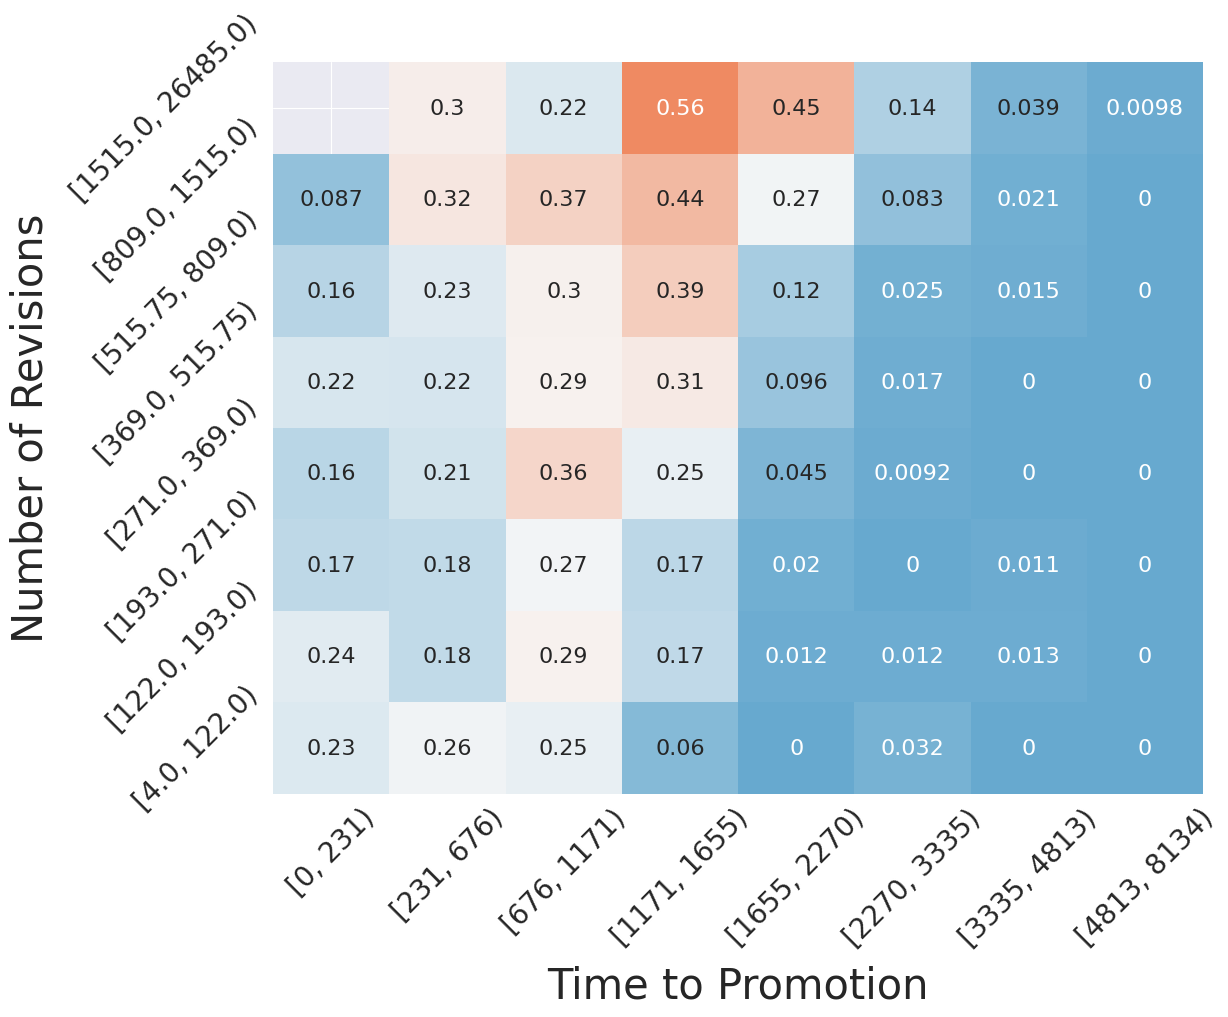

In [59]:
plt.figure(figsize=(12, 9.5))

color_min    = "#67a9cf" # blue
color_center = "#f7f7f7" # white
color_max    = "#ef8a62" # orange
cmap = 'coolwarm_r'
cmap = LinearSegmentedColormap.from_list(
    "cmap_name",
    [color_min, color_center, color_max]
)

# the input for the heat map is the reveresed row in the original pivot table, so rows would be nicely sorted
ax = sns.heatmap(pivot_table.iloc[::-1], annot=True, cmap=cmap, annot_kws={"size": 16}, cbar=include_legend)

# Adjust the color bar label font size
if include_legend:
    cbar = ax.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(14)  # Set the label font size
    cbar.set_label('Mean Unsustainable Articles', labelpad=15, fontsize=30)
    # Set the color bar axis (tick) font size
    cbar.ax.tick_params(labelsize=20)  # Adjust tick font size
    cbar.locator = MaxNLocator(nbins=5)  # Automatically choose up to 5 ticks in the colorbar
    cbar.update_ticks()

plt.xticks(rotation=45, ha='center', fontsize=20) 
plt.yticks(rotation=45, ha='right', fontsize=20) 
#plt.title(f'Heatmap of Binned Feature 1 vs Binned Feature 2 based on Average Target Feature')
plt.xlabel(x_axis_feature, fontsize=30, labelpad=10)
plt.ylabel(y_axis_feature, fontsize=30, labelpad=10)  # labelpad is there in order to add more space in left of the x ticks

# handling the x axis text
if x_axis_feature == 'EDIT_num_authors':
    plt.xlabel('Number of Editors')
elif x_axis_feature == 'EDIT_time_to_promotion':
    plt.xlabel('Time to Promotion')
elif x_axis_feature == 'DISCUSSIONS_num_authors':
    plt.xlabel('Number of Discussers')

# handling the y axis text 
if y_axis_feature == 'COMPOSITION_author_gini':
    plt.ylabel('Gini Index')
elif y_axis_feature == 'EDIT_num_revisions':
    plt.ylabel('Number of Revisions')
elif y_axis_feature == 'DISCUSSIONS_sentiment_mean':
    plt.ylabel('Discussions Sentiment')
# if required to save the fig
if save_fig:
    saving_file_name = 'heatmap_' + x_axis_feature + '_vs_' + y_axis_feature +'.pdf'
    plt.savefig(opj(base_folder, 'models', 'models_analysis', saving_file_name), format="pdf", bbox_inches="tight", dpi=1200)
plt.show()